In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# im2latex(S): Data Analyses and Pruning

&copy; Copyright 2017 Sumeet S Singh

    This file is part of im2latex solution by Sumeet S Singh.

    This program is free software: you can redistribute it and/or modify
    it under the terms of the Affero GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    Affero GNU General Public License for more details.

    You should have received a copy of the Affero GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

# What This Program Does
This notebook curates the [im2latex-100k dataset from Harvard NLP](https://zenodo.org/record/56198#.WT4fsxMrJE4) from a [Harvard NLP project](http://lstm.seas.harvard.edu/latex/) generated using [their code]( https://github.com/Miffyli/im2latex-dataset).

* This notebook loads the data set which are png files generated using [textogif](https://www.fourmilab.ch/webtools/textogif/textogif.html) (via the abovementioned sourcecode)
* Checks and visualizes the data
* Curates the data - whitening etc.
* Converts it to numpy arrays and finally stores it as pickle files.

In [1]:
from __future__ import print_function
import os
import numpy as np
from IPython.display import display, Image as ipImage
import PIL
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [7]:
pd.options.display.max_rows = 600
pd.options.display.max_columns = 20
pd.options.display.max_colwidth = 100
pd.options.display.width = 160
data_folder = '../data/generated2'
image_folder = os.path.join('../data/formula_images_2')

---
View The Images
---------

Let's take a peek at some of the see what it looks like.

---

#### PNG Format Channels
The PNG files in our data have a varying number of channels (4 and 1). Here's a table from [Wikipedia](https://en.wikipedia.org/wiki/Portable_Network_Graphics) explaining the channels.

<table class="wikitable floatright">
<caption>PNG color options<sup id="cite_ref-15" class="reference"><a href="#cite_note-15">[15]</a></sup></caption>
<tbody><tr>
<th colspan="7">Bits per pixel</th>
</tr>
<tr>
<th rowspan="2">Color option</th>
<th rowspan="2">Channels</th>
<th colspan="5">Bits per channel</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>4</th>
<th>8</th>
<th>16</th>
</tr>
<tr>
<th>Indexed</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
</tr>
<tr>
<th>Grayscale</th>
<th>1</th>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">1</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">2</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">4</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">8</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
</tr>
<tr>
<th>Grayscale and alpha</th>
<th>2</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">16</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
</tr>
<tr>
<th>Truecolor</th>
<th>3</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">24</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">48</td>
</tr>
<tr>
<th>Truecolor and alpha</th>
<th>4</th>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#F99;vertical-align:middle;text-align:center;" class="table-no"></td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">32</td>
<td style="background:#9F9;vertical-align:middle;text-align:center;" class="table-yes">64</td>
</tr>
</tbody></table>

We'll load files using the flatten=True flag so that the RGB channels get flattened into a single grayscale value.

In [8]:
def displayRandImage(root):
    path = os.path.join(root, np.random.choice(filter(lambda f: f.endswith('.png'),os.listdir(root))));
    image_data = ndimage.imread(path)
    print(path, ' ', image_data.shape)
    display(ipImage(filename=path, format='png', unconfined=True))
    print(ipImage)
    return [path, image_data, image_data.shape]


../data/formula_images_2/31b951bf414164d_basic.png   (68, 487)


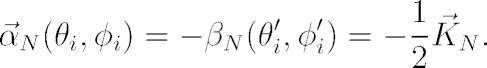

<class 'IPython.core.display.Image'>
../data/formula_images_2/446386326295a19_basic.png   (34, 451)


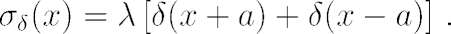

<class 'IPython.core.display.Image'>
../data/formula_images_2/ea3fd7e6f07109f_basic.png   (158, 1024, 4)


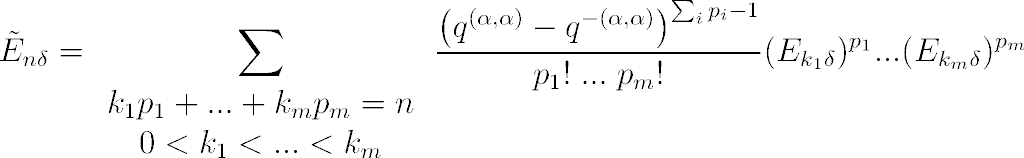

<class 'IPython.core.display.Image'>
../data/formula_images_2/e5600778b85a78c_basic.png   (114, 895, 4)


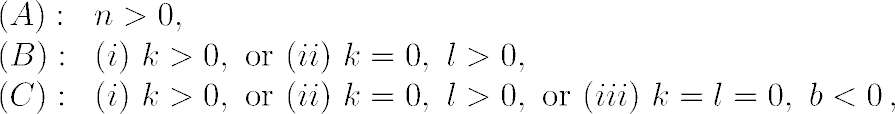

<class 'IPython.core.display.Image'>
../data/formula_images_2/9920b3d08dab040_basic.png   (72, 1062, 4)


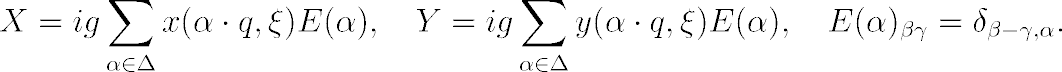

<class 'IPython.core.display.Image'>
../data/formula_images_2/aca844ba591db9d_basic.png   (106, 632)


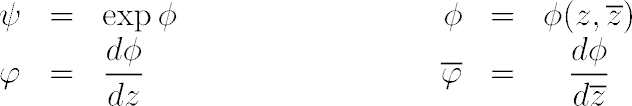

<class 'IPython.core.display.Image'>
../data/formula_images_2/ddc92e0cb3c197c_basic.png   (36, 333)


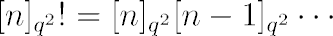

<class 'IPython.core.display.Image'>
../data/formula_images_2/4f448effb761c0f_basic.png   (95, 859)


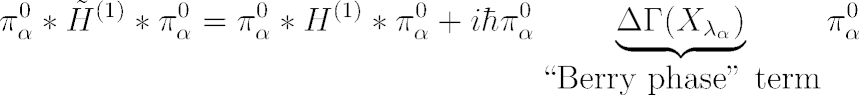

<class 'IPython.core.display.Image'>
../data/formula_images_2/d3f728e0e47f856_basic.png   (42, 455)


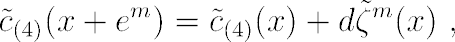

<class 'IPython.core.display.Image'>
../data/formula_images_2/9b7a9de6173bed5_basic.png   (96, 534)


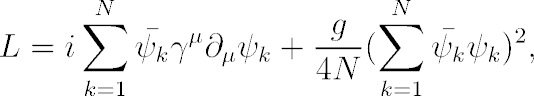

<class 'IPython.core.display.Image'>


In [9]:
image_details = [displayRandImage(image_folder) for _ in range(10)]

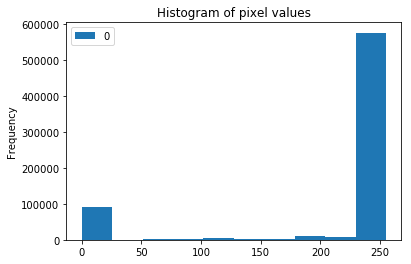

In [5]:
# Histogram the pixel values
vals = np.array([])
for i in range(len(image_details)):
    vals = np.append(vals, image_details[i][1].flatten())


pd.DataFrame(vals).plot.hist(title='Histogram of pixel values')

---
## View Data after Loading into NDArray
---

In [10]:
def loadImage(path, mode="RGB"):
    # Flatten=True collapses the RGB channels into a single grayscale
    #return ndimage.imread(path, flatten=True)
    return ndimage.imread(path, mode=mode)

def _loadImage(path, mode="RGB"):
    img = Image.open(path)
    img = img.convert(mode)
    return np.asarray(img)

def plotImage(path, axes):
    image_data = loadImage(path)
    title = os.path.splitext(os.path.basename(path))[0] + ' %s'%(image_data.shape,)
    axes.set_title( title )
    axes.set_xlim(-10,1500)
    axes.imshow(image_data, aspect='equal', extent=None, resample=False, interpolation='bilinear')
    return [path, image_data, image_data.shape]

def plotImages(image_details, dpi=None):
    """ image_details should be an array of image path and width - [[path, image_data, image_data.shape], ...] """
    ## Display image data loaded as a numpy array
    try:
        plt.close(fig)
    except:
        pass
    orig_dpi = plt.rcParams['figure.dpi']
    image_data = []    
    with mpl.rc_context(rc={'figure.dpi': dpi or orig_dpi}):
        print('dpi set to %d'%mpl.rcParams['figure.dpi'])
        fig = plt.figure(figsize=(15.,3.*len(image_details)))
        grid = ImageGrid(fig, 111, nrows_ncols=(len(image_details),1), axes_pad=(0.1, 0.5), label_mode="L", aspect=False)
        for i in range(len(image_details)):
            image_data.append(plotImage(image_details[i][0], grid[i]))
        
    return image_data

dpi set to 200


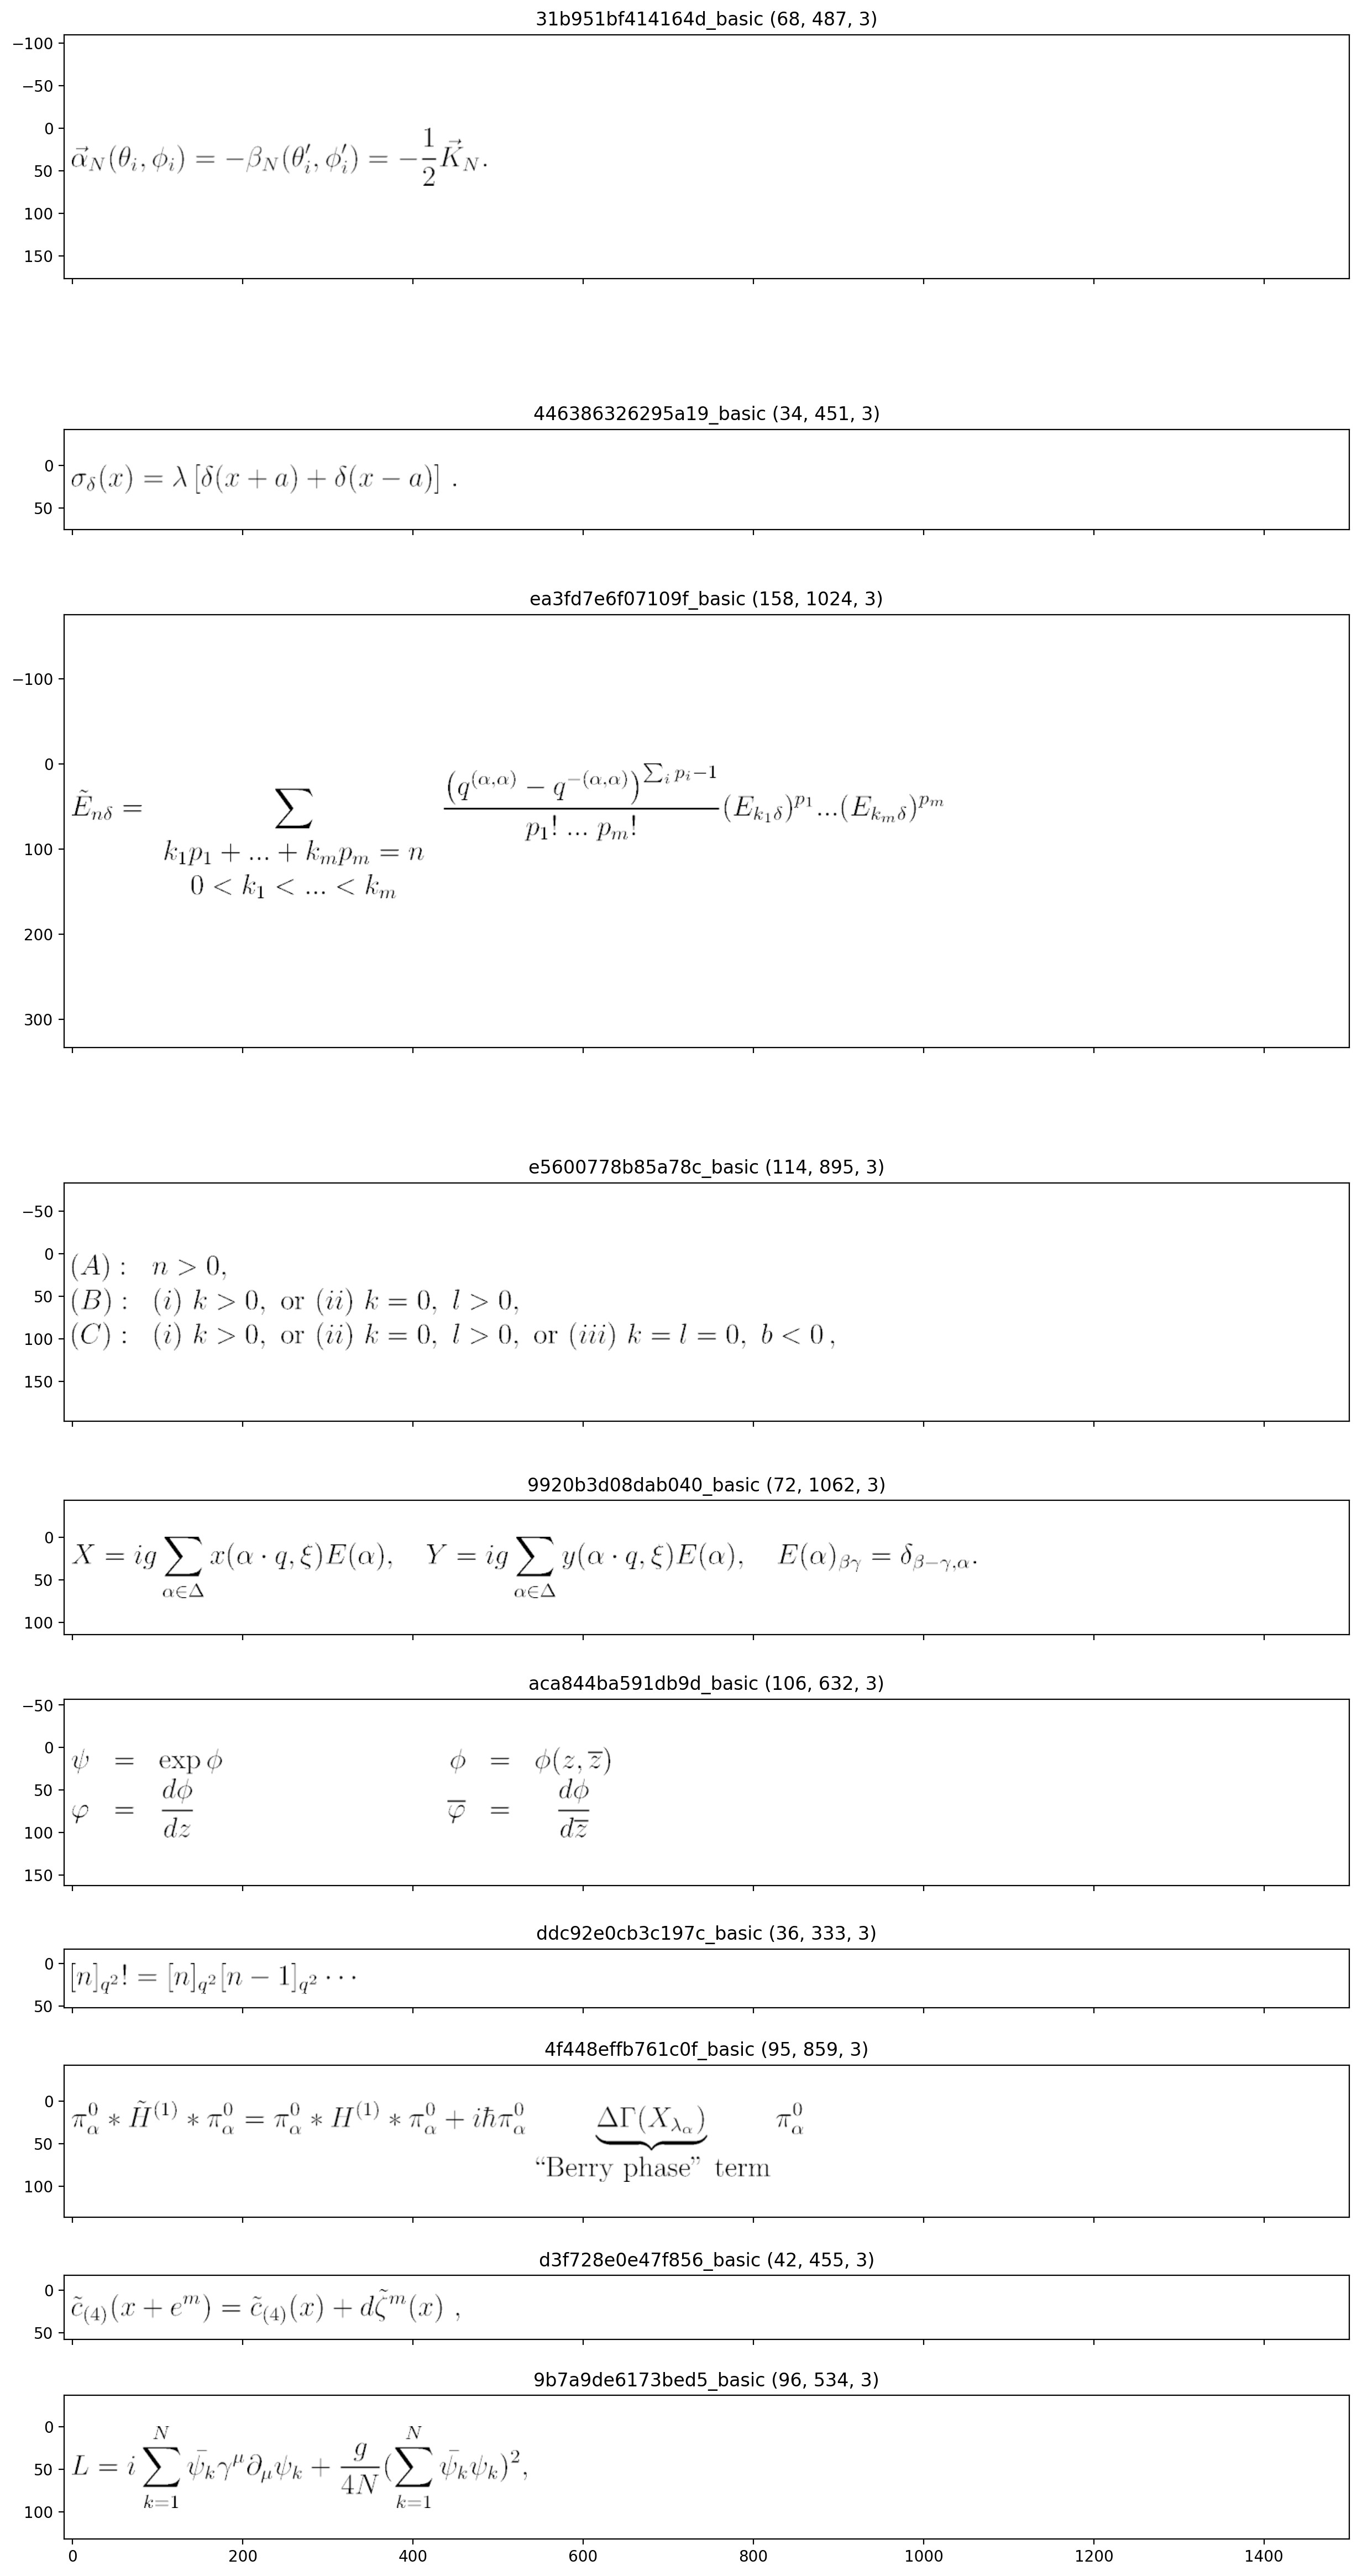

In [13]:
image_details2 = plotImages(image_details, dpi=200)

In [10]:
# for i in range(len(image_details2)):
#     print (np.array_equal(image_details2[i][1] , image_details2_[i][1]))

min pixel=0.000000, max=255.000000


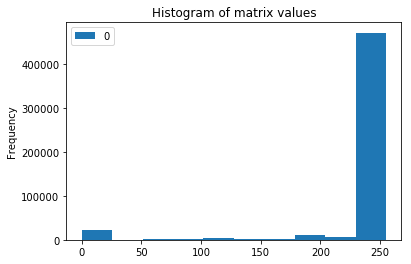

In [9]:
# Histogram the matrix values
vals2 = np.array([])
for i in range(len(image_details2)):
    vals2 = np.append(vals, image_details2[i][1].flatten())

print ('min pixel=%f, max=%f'%(vals2.min(), vals2.max()))
pd.DataFrame(vals2).plot.hist(title='Histogram of matrix values')

In [10]:
# images = filter(lambda s: s.endswith('.png'), os.listdir(image_folder))
# sizes = []
# for image in images:
#     try:
#         im = Image.open(os.path.join(image_folder,image))
#         sizes.append(im.size)
#     except Exception as e:
#         #print(e)
#         pass
    
# print (len(sizes))
# len(images)

-------
## Latex Word Sequence Lengths

-------

In [11]:
dff_all = pd.read_pickle(os.path.join(data_folder, 'df_word2id.pkl'))

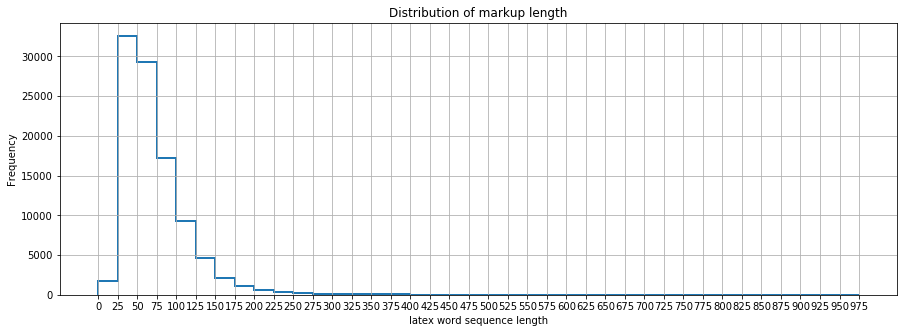

In [12]:
axes = plt.axes()
axes.set_xlabel('latex word sequence length')
axes.set_title('Distribution of markup length')
bins=range(0,1000,25)
dff_all.word2id_len.plot.hist(ax=axes, histtype='step', lw=2,  figsize=(15,5), grid=True, bins=bins, xticks=bins)

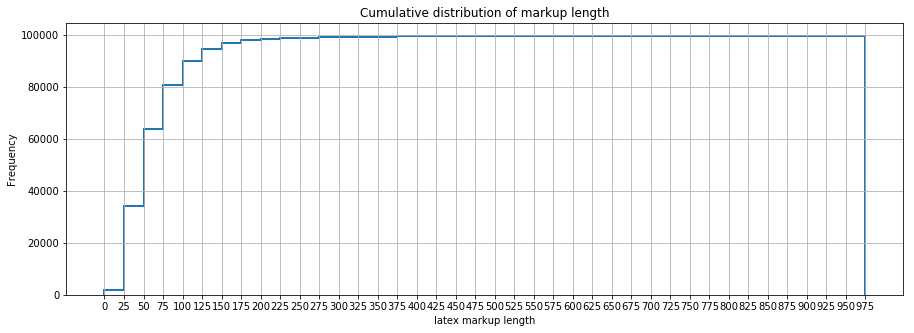

In [13]:
axes = plt.axes()
axes.set_xlabel('latex markup length')
axes.set_title('Cumulative distribution of markup length')
bins=range(0,1000,25)
dff_all.word2id_len.plot.hist(ax=axes, histtype='step', lw=2, bins=bins, xticks=bins, figsize=(15,5), grid=True, cumulative=True)

In [14]:
display(dff_all.word2id_len.quantile((.60,.70,.75,.80,.85,.90,.95,.97,.98,.99,1.0)))

0.60     70.0
0.70     82.0
0.75     89.0
0.80     97.0
0.85    108.0
0.90    123.0
0.95    148.0
0.97    171.0
0.98    191.0
0.99    238.0
1.00    869.0
Name: word2id_len, dtype: float64

### Conclusion of Formula Length Analyses
For training efficiency it will be desirable to batch together formulas of equal length. Also, since 95% of the formulas are below 150 tokens long, we'll limit our training set to under 150 tokens - which will leave us with ~95K samples (see below).

In [15]:
dff_l = dff_all[dff_all.word2id_len <= 150]
dff_l.shape[0]

94873

In [16]:
dff_l.word2id_len.apply(lambda x: x**2).describe()

count    94873.000000
mean      5170.385041
std       4625.911018
min        121.000000
25%       1764.000000
50%       3481.000000
75%       7056.000000
max      22500.000000
Name: word2id_len, dtype: float64

In [17]:
display(dff_all[['word2id_len', 'width', 'height']].corr())
display(dff_all.max())

,word2id_len,width,height
word2id_len,1.000000,0.688010,0.593184
width,0.688010,1.000000,0.242407
height,0.593184,0.242407,1.000000


image                                                                                        ffff99cc5bfff61_basic.png
formula_name                                                                                     ffff99cc5bfff61_basic
latex              ~~~=-\frac{1}{24\pi}g_{\gamma \delta }R \sigma ^{;\gamma }\sigma ^{;\delta }+\frac{1}{96\pi} g_{...
formula_len                                                                                                        991
height                                                                                                            1491
width                                                                                                             1532
latex_ascii        ~~~=-\frac{1}{24\pi}g_{\gamma \delta }R \sigma ^{;\gamma }\sigma ^{;\delta }+\frac{1}{96\pi} g_{...
latex_ascii_len                                                                                                    989
latex_tokenized    [~, ~, ~, =, -, \frac, {, 1, 

In [18]:
dff_all[dff_all.height>=400].shape

(76, 11)

---
## Image Width Analysis
Since images are of varying sizes, we'll need to standardize/quantize their shapes by padding around them. First we need to check the sizes.

---

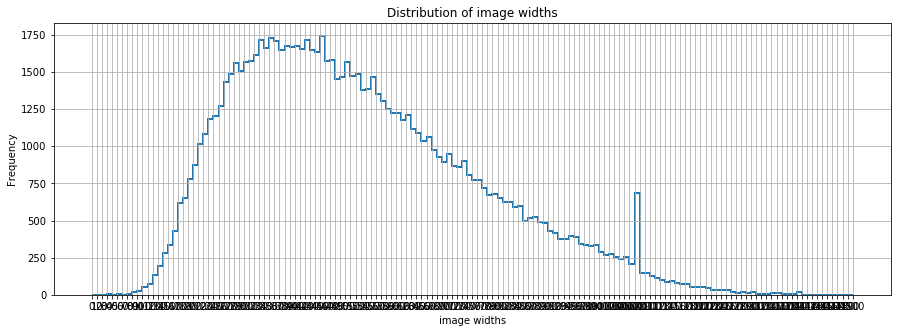

In [19]:
axes = plt.axes()
axes.set_xlabel('image widths')
axes.set_title('Distribution of image widths')
bins=range(0,1501,10)
dff_l['width'].plot.hist(histtype='step', bins=bins, xticks=bins, figsize=(15,5), grid=True, lw=2)

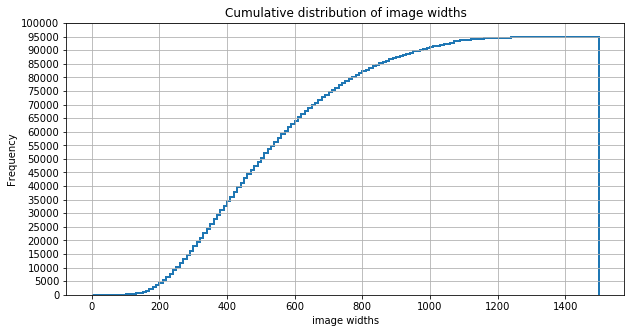

In [20]:
axes = plt.axes()
axes.set_xlabel('image widths')
axes.set_ylabel('Cumulative Count')
axes.set_title('Cumulative distribution of image widths')
dff_l['width'].plot.hist(histtype='step',bins=range(0,1501,10), yticks=range(0,105000,5000), figsize=(10,5), grid=True, cumulative=True, lw=2)

In [21]:
dff_l.width.quantile((.60,.65,.70,.75,.80,.85,.90,.95,.96,.97,.98,.99,1.0))

0.60     554.00
0.65     590.00
0.70     629.00
0.75     674.00
0.80     725.00
0.85     786.00
0.90     864.00
0.95     978.00
0.96    1007.00
0.97    1042.00
0.98    1075.00
0.99    1124.28
1.00    1391.00
Name: width, dtype: float64

### Conclusion of Width Analysis
We'll standardize the width of all images to 1075 (98 percentil point) by padding the smaller ones. We could've gone with a much lower number - specifically the 85% cutoff point but that would've left us with only 80K samples. At this time we want to ensure close to 100K samples, therefore we'll settle for a width of 1075, which gives us 93K samples.

In [22]:
dff_lw = dff_l[dff_l.width <= 1075]
dff_lw.shape

(93090, 11)

### Image Height Analysis

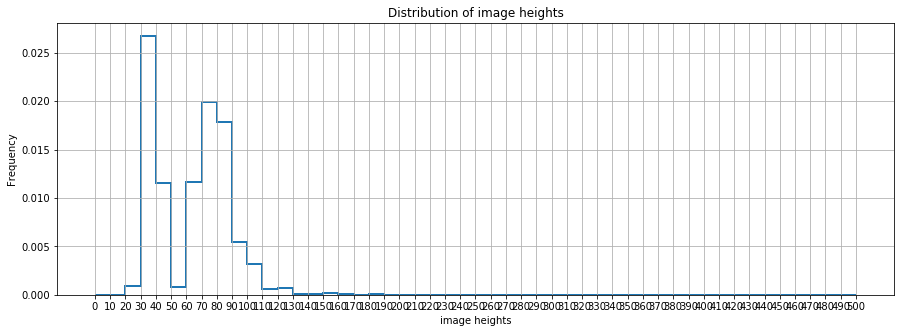

In [23]:
axes = plt.axes()
axes.set_xlabel('image heights')
axes.set_title('Distribution of image heights')
bins=range(0,501,10)
dff_lw['height'].plot.hist(ax=axes, histtype='step', lw=2, bins=bins, figsize=(15,5), grid=True, xticks=bins, normed=True)

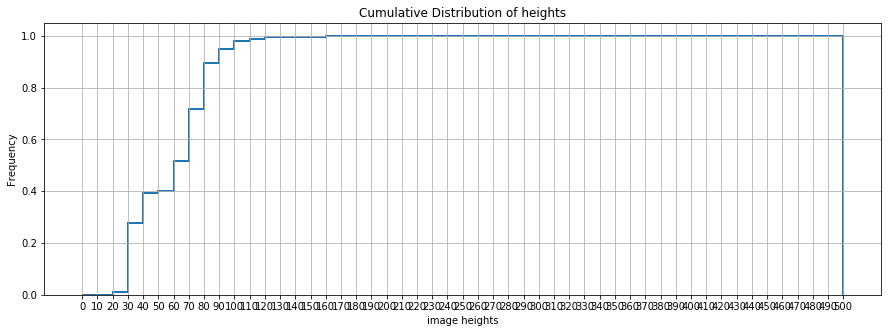

In [24]:
axes = plt.axes()
axes.set_xlabel('image heights')
axes.set_title('Cumulative Distribution of heights')
bins=range(0,501,10)
dff_lw['height'].plot.hist(histtype='step', lw=2, bins=bins, xticks=bins, figsize=(15,5), grid=True, normed=True, cumulative=True)

In [25]:
display(dff_lw.height.quantile((.85,.90,.95,.96,.97,.98,.985,.99,1.0)))

0.850      84.0
0.900      90.0
0.950      99.0
0.960     100.0
0.970     101.0
0.980     107.0
0.985     114.0
0.990     120.0
1.000    1490.0
Name: height, dtype: float64

In [26]:
dff_lwh = dff_lw[dff_lw.height<=120]
dff_lwh.shape

(92283, 11)

## Conclusion
Note that there is a big difference between the 99% and 100% height values. And since the image is much wider than it is tall, a reduction in the height of the image will be much more impactful than a similar reduction in its width. Hence, we'll select images that are 120 or fewer pixels high. That will leave us with ~92K samples.

In conclusion, we'll set all images to a size of 120 x 1075. Images smaller than this dimension will be padded equally on both sides with whites (value 255) while images wider or taller will be discarded from the training, validation or test sets.

Furthermore, the images will be batched together according to the sequence length of the formulas.

## Pixel Value Analysis
Find out if we can simplify the dataset to bitmaps. This would greatly simplify the learning and also reduce the memory required for storing the data.

In [1]:
def getValuesDF(dff, data_dir):
    try:
        return pd.read_csv(os.path.join(data_dir,'df_lwh_pixel_dist.pkl'), index_col=0)
    except:
        raise
    vals = pd.Series([])
    for filename in dff.image:
        image_data = ndimage.imread(os.path.join(data_dir,'formula_images',filename), mode='L')
        vals = vals.add(pd.Series(image_data.flatten()).value_counts(), fill_value=0)

    dV = pd.DataFrame({'pixel_value':vals.index, 'val_count':vals}, columns=['pixel_value', 'val_count'])
    dV.to_pickle(os.path.join(data_dir,'df_lwh_pixel_dist.pkl'))
    return dV

dV = getValuesDF(dff_lwh, data_folder)
dV.T

NameError: name 'dff_lwh' is not defined

NameError: name 'dV' is not defined

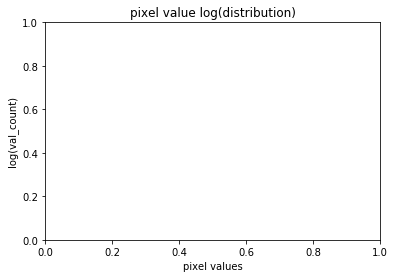

In [28]:
\omega _{\mu \nu }=\partial _{\mu }v_{\nu }-\partial _{\nu }v_{\mu }axes = plt.axes()
axes.set_xlabel('pixel values')
axes.set_ylabel('log(val_count)')
axes.set_title('pixel value log(distribution)')
dV['val_count'].plot(ax=axes, kind='line', figsize=(10,5), xticks=range(0,255, 10), logy=True, linewidth=2, grid=True, xlim=(-10, 265))

In [ ]:
axes = plt.axes()
axes.set_xlabel('pixel values')
axes.set_ylabel('cumulative % count')
((dV['val_count'].cumsum() / dV['val_count'].sum())*100).plot(ax=axes, kind='area', figsize=(10,5), xticks=range(0,255, 10), yticks=range(0,101,5), linewidth=2, grid=True, xlim=(-10, 265), ylim=(-5, 105), title='pixel value cumulative sum')

---
### Conclusion of Pixel Value Analysis
The above analysis shows that though the data distribution is heavily skewed around values 255 (white) and 0 (black), there are some significant bumps at values 124, 179 and 221. Therefore, we'll leave the images as grayscale for now.

---

In [ ]:
dff_lwh.to_pickle(os.path.join(data_folder, 'df_pruned.pkl'))